In [1]:
import numpy as np
import stim
from matplotlib import pyplot as plt

## Basic circuit

In [2]:
circuit = stim.Circuit()

# First, the circuit will initialize a Bell pair.
circuit.append("H", [0])
circuit.append("CNOT", [0, 1])

# Then, the circuit will measure both qubits of the Bell pair in the Z basis.
circuit.append("M", [0, 1])

circuit.diagram()

q0: -H-@-M:rec[0]-
       |
q1: ---X-M:rec[1]-

In [3]:
sampler = circuit.compile_sampler()
print(sampler.sample(shots=10))

[[ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [False False]
 [ True  True]
 [ True  True]
 [False False]
 [False False]
 [False False]]


## Detector annotations

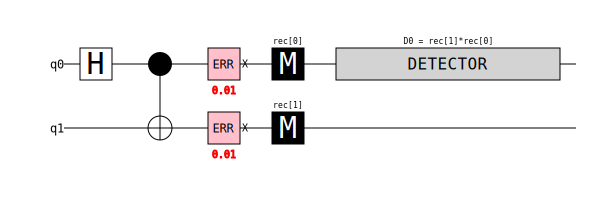

In [4]:
error_p = 0.01
circuit = stim.Circuit()
circuit.append("H", [0])
circuit.append("CNOT", [0, 1])
circuit.append("X_ERROR", [0, 1], error_p)
circuit.append("M", [0, 1])
circuit.append("DETECTOR", [stim.target_rec(-1), stim.target_rec(-2)])
circuit.diagram("timeline-svg")

In [5]:
shots = 10**6

sampler = circuit.compile_sampler()
p_ij = sampler.sample(shots)
print(np.unique(p_ij, return_counts=True, axis=0))

sampler = circuit.compile_detector_sampler()
p_ij = sampler.sample(shots)
print(np.unique(p_ij, return_counts=True))
print(np.sum(p_ij) / shots, 2 * error_p * (1 - error_p))

(array([[False, False],
       [False,  True],
       [ True, False],
       [ True,  True]]), array([490473,   9885,   9856, 489786]))
(array([False,  True]), array([980123,  19877]))
0.019877 0.0198


## Repetition code

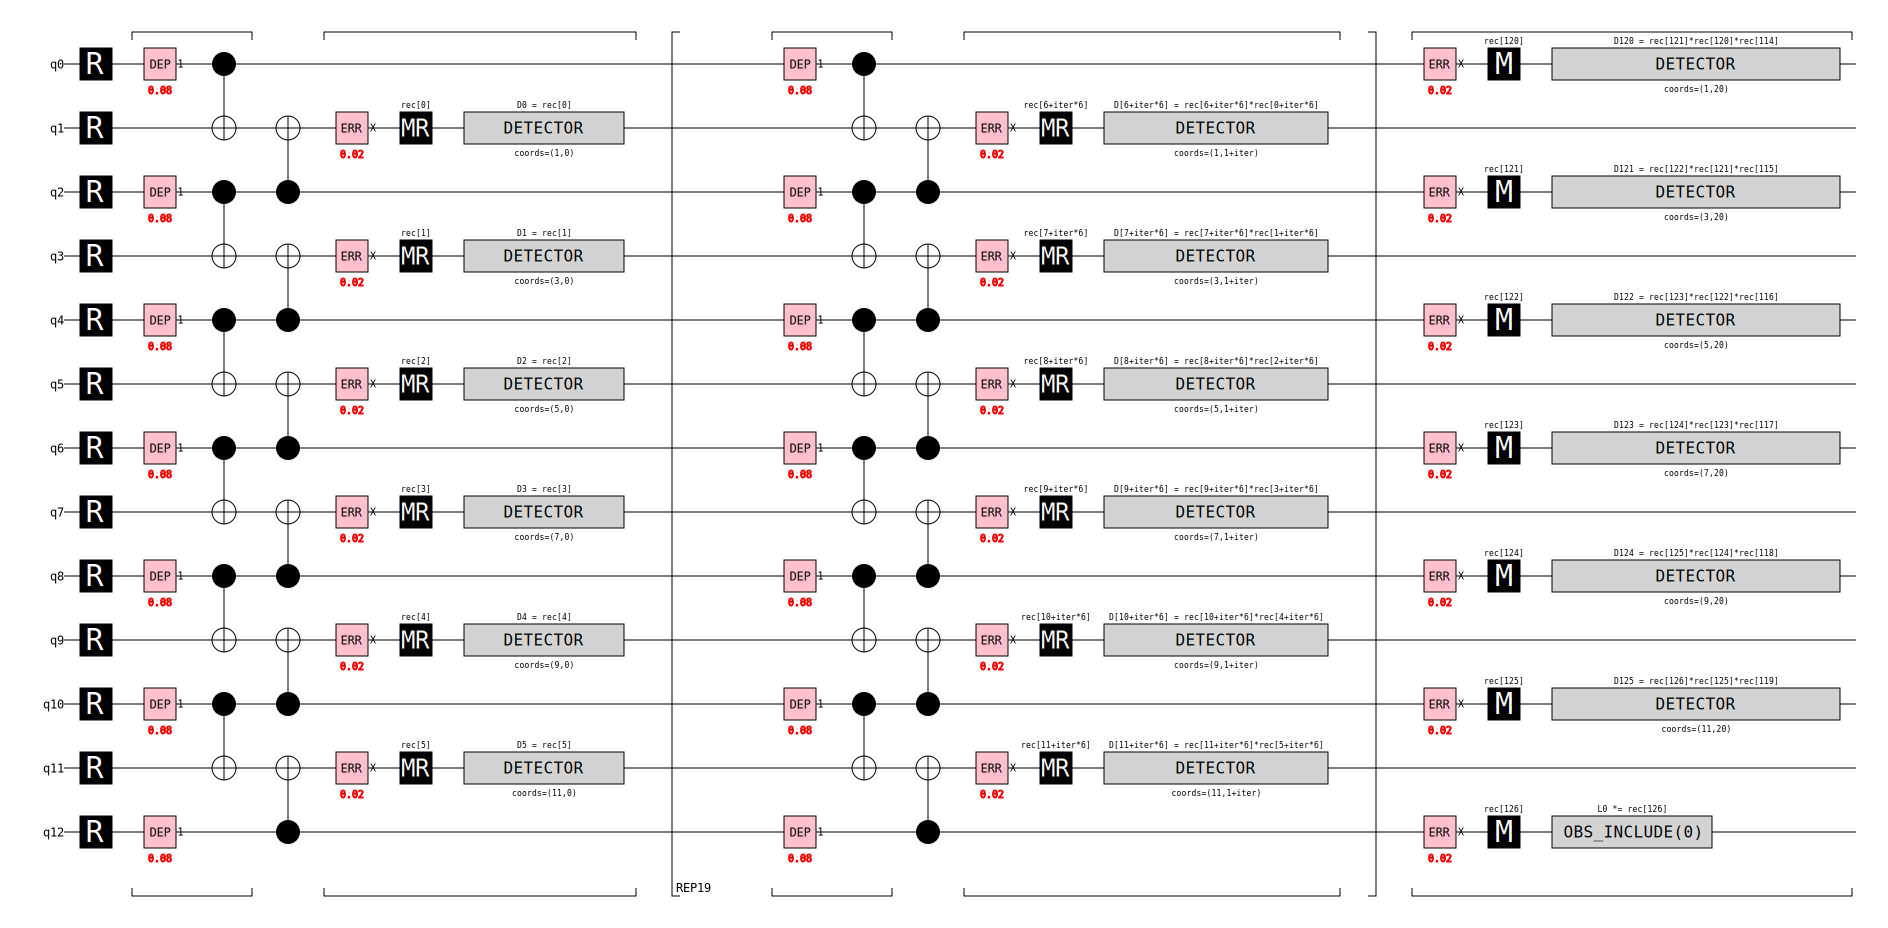

In [6]:
distance = 7
rounds = 20
circuit = stim.Circuit.generated(
    "repetition_code:memory",
    distance=distance,
    rounds=rounds,
    before_round_data_depolarization=0.08,
    before_measure_flip_probability=0.02,
)
circuit.diagram("timeline-svg")

### DEF

(1000000, 126)
(21, 6)


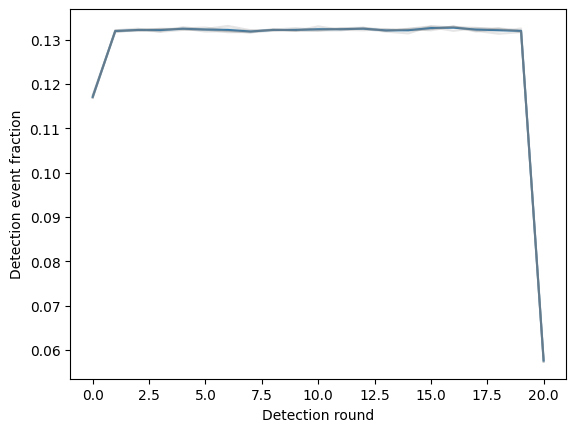

In [7]:
shots = 10**6
detector_sampler = circuit.compile_detector_sampler()
detector_sample = detector_sampler.sample(shots)
print(detector_sample.shape)

res: np.ndarray = detector_sample.mean(axis=0).reshape((rounds + 1, distance - 1))
print(res.shape)

plt.plot(res.mean(axis=1))
plt.plot(res, "gray", alpha=0.2)
plt.xlabel("Detection round")
plt.ylabel("Detection event fraction")
plt.show()

### Correlation matrix

In [8]:
xi = detector_sample.mean(axis=0)
xi_xj = np.einsum('ij,ik->ijk', detector_sample, detector_sample).mean(axis=0)
print(xi.shape)
print(xi_xj.shape)

(126,)
(126, 126)


In [9]:
# Space-first
p_ij = (xi_xj - np.outer(xi, xi)) / np.outer(1 - 2 * xi, 1 - 2 * xi)
np.fill_diagonal(p_ij, 0)
print(p_ij.shape)

(126, 126)


In [10]:
# Time-first
p_ij_t = p_ij.reshape((rounds + 1, distance - 1, rounds + 1, distance - 1)).transpose(1, 0, 3, 2)
p_ij_t = p_ij_t.reshape((rounds + 1) * (distance - 1), (rounds + 1) * (distance - 1))
print(p_ij_t.shape)

(126, 126)


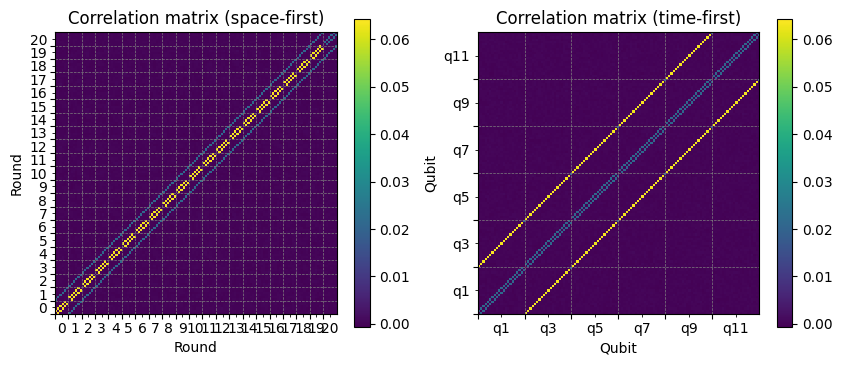

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# First subplot
im1 = axs[0].imshow(p_ij, interpolation="none")
fig.colorbar(im1, ax=axs[0])
axs[0].set_title("Correlation matrix (space-first)")
axs[0].set_xlabel("Round")
axs[0].set_ylabel("Round")
axs[0].invert_yaxis()

ticks = np.arange(rounds + 1) * (distance - 1) - 0.5
labels = range(rounds + 1)

axs[0].set_xticks(ticks, [])
axs[0].set_xticks(ticks + (distance - 1) / 2, labels, minor=True)
axs[0].set_yticks(ticks, [])
axs[0].set_yticks(ticks + (distance - 1) / 2, labels, minor=True)
axs[0].grid(which="major", color="gray", linestyle="--", linewidth=0.5)

# Second subplot
im2 = axs[1].imshow(p_ij_t, interpolation="none")
fig.colorbar(im2, ax=axs[1])
axs[1].set_title("Correlation matrix (time-first)")
axs[1].set_xlabel("Qubit")
axs[1].set_ylabel("Qubit")
axs[1].invert_yaxis()

ticks = np.arange(distance - 1) * (rounds + 1) - 0.5
labels = [f"q{i * 2 + 1}" for i in range(distance - 1)]

axs[1].set_xticks(ticks, [])
axs[1].set_xticks(ticks + (rounds + 1) / 2, labels, minor=True)
axs[1].set_yticks(ticks, [])
axs[1].set_yticks(ticks + (rounds + 1) / 2, labels, minor=True)
axs[1].grid(which="major", color="gray", linestyle="--", linewidth=0.5)

plt.show()

### S and T errors

In [15]:
# Boundary error probabilities

def g(p, q):
    return p + q - 2 * p * q

p_i_s1 = np.zeros_like(xi)
p_i_s2 = np.zeros_like(xi)
for i in range(p_ij_t.shape[0]):
    p_i_s1[i] = p_ij_t[i, 0]
    p_i_s2[i] = p_ij_t[i, -rounds - 1]
    for j in range(rounds):
        p_i_s1[i] = g(p_ij_t[i, j + 1], p_i_s1[i])
        p_i_s2[i] = g(p_ij_t[i, j - rounds], p_i_s2[i])

p_i_b1 = (xi - p_i_s1) / (1 - 2 * p_i_s1)
p_i_b2 = (xi - p_i_s2) / (1 - 2 * p_i_s2)

print(p_i_b1[:rounds + 1].shape)
print(p_i_b2[-rounds - 1:].shape)

(21,)
(21,)


In [13]:
t_edges = np.array([
    i[:-1] for i in np.split(np.append(p_ij_t.diagonal(1), 0), distance - 1)
])
print(t_edges.shape)

s_edges = np.array(np.split(p_ij_t.diagonal(rounds + 1), distance - 2))
s_edges = np.vstack((p_i_b1[:rounds + 1], s_edges, p_i_b2[-rounds - 1:]))
print(s_edges.shape)

(6, 20)
(7, 21)


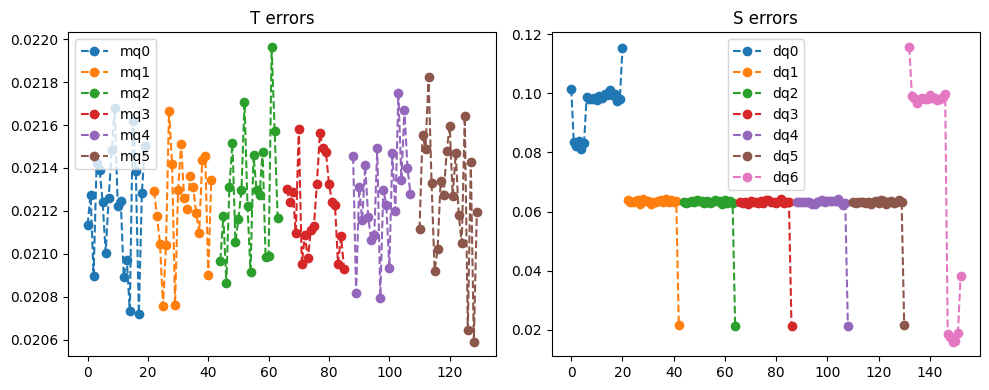

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot T errors
for i, edge in enumerate(t_edges):
    axs[0].plot(np.arange(len(edge)) + i * (rounds + 2), edge, "o--", label=f"mq{i}")
axs[0].legend()
axs[0].set_title("T errors")

# Plot S errors
for i, edge in enumerate(s_edges):
    axs[1].plot(np.arange(len(edge)) + i * (rounds + 2), edge, 'o--', label=f'dq{i}')
axs[1].legend()
axs[1].set_title("S errors")

plt.tight_layout()
plt.show()